In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.enable_eager_execution()

In [3]:
mnist = tf.keras.datasets.mnist.load_data(path='/home/art/Documents/data/mnist.npz')

In [4]:
((x_train, y_train), (x_test, y_test)) = mnist

In [5]:
batch_size = 10

In [6]:
loc_normd = tf.random_uniform((batch_size, 2), minval=-1, maxval=1)

In [7]:
img = x_train[:batch_size, :, :, np.newaxis]

In [32]:
class GlimpseSensor(tf.keras.Model):
    """glimpse sensor, returns retina-like representation rho
    of a region of an image x, given a location l to 'fixate'.
    """

    def __init__(self, g_w=8, k=3, s=2):
        """__init__ for GlimpseSensor

        Parameters
        ----------
        g_w : int
            length of one side of square patches in glimpses extracted by glimpse sensor.
            Default is 8.
        k : int
            number of patches that the retina encoding rho(x,l) extracts
            at location l from image x. Default is 3.
        s : int
            scaling factor, controls size of successive patches. Default is 2.
        """
        super(GlimpseSensor, self).__init__()
        self.g_w = g_w
        self.k = k
        self.s = s

    def glimpse(self, images, loc_normd):
        """take a "glimpse" of a batch of images.
        Returns retina-like representation rho(img, loc)
        consisting of patches from each image.

        Parameters
        ----------
        images : tf.Tensor
            with shape (B, H, W, C). Minibatch of images.
        loc_normd : tf.Tensor
            with shape (B, 2). Location of retina "fixation",
            in normalized co-ordinates where center of image is (0,0),
            upper left corner is (-1,-1), and lower right corner is (1,1).

        Returns
        -------
        rho : tf.Tensor
            with shape (B, k, g_w, g_w,
            retina-like representation of k patches of increasing size
            and decreasing resolution, centered around location loc within
            image img
        """
        batch_size, img_H, img_W, C = images.shape
        # convert image co-ordinates from normalized to co-ordinates within
        # the specific size of the images
        loc_0 = ((loc_normd[:, 0] + 1) / 2) * img_H
        loc_0 = tf.cast(tf.round(loc_0), tf.int32)
        loc_1 = ((loc_normd[:, 1] + 1) / 2) * img_W
        loc_1 = tf.cast(tf.round(loc_1), tf.int32)
        loc = tf.stack([loc_0, loc_1], axis=1)

        rho = []
        for ind in range(batch_size):
            img = images[ind, :, :, :]
            patches = []
            for patch_num in range(self.k):
                size = self.g_w * (self.s ** patch_num)

                # pad image with zeros
                # (in case patch at current location extends beyond edges of image)
                img_padded = tf.image.pad_to_bounding_box(img,
                                                          offset_height=size,
                                                          offset_width=size,
                                                          target_height=(size * 2) + img_H,
                                                          target_width=(size * 2) + img_W)

                # compute top left corner of patch
                patch_x = loc[ind, 0] - (size // 2) + size
                patch_y = loc[ind, 1] - (size // 2) + size

                patch = tf.slice(img_padded,
                                 begin=tf.stack([patch_x, patch_y, 0]),
                                 size=tf.stack([size, size, C])
                                 )
                if size == self.g_w:
                    # convert to float32 to be consistent with
                    # tensors output after resizing
                    patch = tf.cast(patch, dtype=tf.float32)
                else:
                    # resize cropped image to (size x size)
                    patch = tf.image.resize_images(patch, size=(self.g_w, self.g_w))
                patches.append(patch)

            rho.append(patches)

        rho = tf.stack(rho)
        return rho


In [33]:
sensor = GlimpseSensor()

In [35]:
rho = sensor.glimpse(img, loc_normd)

In [43]:
tf.squeeze(rho[ind, 0, :, :, :]).shape

TensorShape([Dimension(8), Dimension(8)])

ValueError: Colormap grey is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

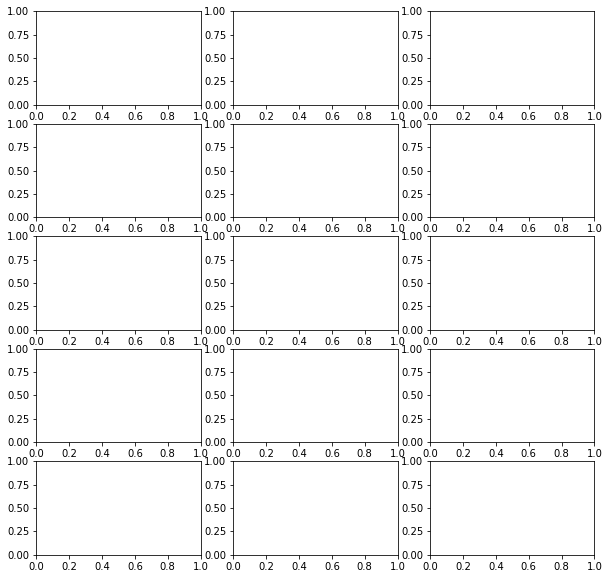

In [45]:
# plot some patches as a sanity check
fig, ax = plt.subplots(5, 3)
fig.set_size_inches(10, 10)
for ind in range(5):
    ax[ind, 0].pcolormesh(tf.squeeze(rho[ind, 0, :, :, :]), cmap='grey')
    ax[ind, 1].pcolormesh(tf.squeeze(rho[ind, 1, :, :, :]), cmap='grey')
    ax[ind, 2].pcolormesh(tf.squeeze(rho[ind, 2, :, :, :]), cmap='grey')